In [34]:
# ----------------------------
# Import Necessary Libraries
# ----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# ----------------------------
# Mars Color Scheme
# ----------------------------
MARS_COLORS = {
    'background': '#D4A574',
    'grid': '#000000',
    'blue': '#2E86AB',
    'green': '#06A77D',
    'red': '#D62828',
    'purple': '#7209B7',
    'text': '#1A1A1A'
}

PALETTE = [
    MARS_COLORS['blue'],
    MARS_COLORS['green'],
    MARS_COLORS['red'],
    MARS_COLORS['purple']
]

plt.rcParams.update({
    'figure.facecolor': MARS_COLORS['background'],
    'axes.facecolor': MARS_COLORS['background'],
    'axes.edgecolor': MARS_COLORS['grid'],
    'axes.labelcolor': MARS_COLORS['text'],
    'xtick.color': MARS_COLORS['text'],
    'ytick.color': MARS_COLORS['text'],
    'text.color': MARS_COLORS['text'],
})

In [36]:
# ----------------------------
# Load Dataset
# ----------------------------
df = pd.read_csv("data/processed/reports_final_with_all_features.csv")

In [38]:
# ----------------------------
# Create Key Variables
# ----------------------------

# Outcome: overload proxy
df["over_capacity"] = (df["agents"] > df["capacity"]).astype(int)

# Treatment: high load
df["high_load"] = (df["load_factor"] > 0.75).astype(int)

# Simple utilization metric
df["utilization"] = df["agents"] / df["capacity"]

In [40]:
# ----------------------------
# EconML Setup
# ----------------------------

# Variable Definition

# Outcome
Y = df["over_capacity"].values

# Treatment
T = df["high_load"].values.reshape(-1, 1)

# Confounders (keep it minimal + interpretable)
X = df[["utilization", "agents", "capacity"]].values

In [42]:
# ---------------------------------
# Residualize the Outcome (Y ⟂ X)
# ---------------------------------

# Model outcome using confounders
model_y = LinearRegression()
model_y.fit(X, Y)

# Residualized outcome
Y_resid = Y - model_y.predict(X)

In [44]:
# -----------------------------------
# Residualize the Treatment (T ⟂ X)
# -----------------------------------

model_t = LinearRegression()
model_t.fit(X, T)

# Residualized treatment
T_resid = T.flatten() - model_t.predict(X).flatten()

In [46]:
# ----------------------------------
# Casual Effect by Final Regression
# ----------------------------------

final_model = LinearRegression()
final_model.fit(T_resid.reshape(-1, 1), Y_resid)

ate_manual = final_model.coef_[0]
print("Manual DML-style ATE:", ate_manual)

Manual DML-style ATE: 0.0016291512232311236


In [48]:
# ----------------------------------
# Linear Model
# ----------------------------------

treatment_effect = ate_manual * T_resid

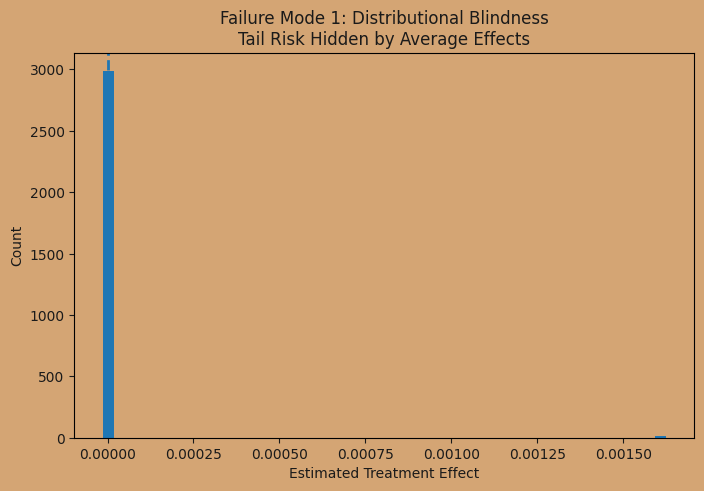

In [52]:
# ----------------------------
# Distributional Blindness
# ----------------------------

plt.figure(figsize=(8, 5))
plt.hist(treatment_effect, bins=50)
plt.axvline(treatment_effect.mean(), linestyle='--', linewidth=2)

plt.title("Failure Mode 1: Distributional Blindness\nTail Risk Hidden by Average Effects")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Count")

plt.show()

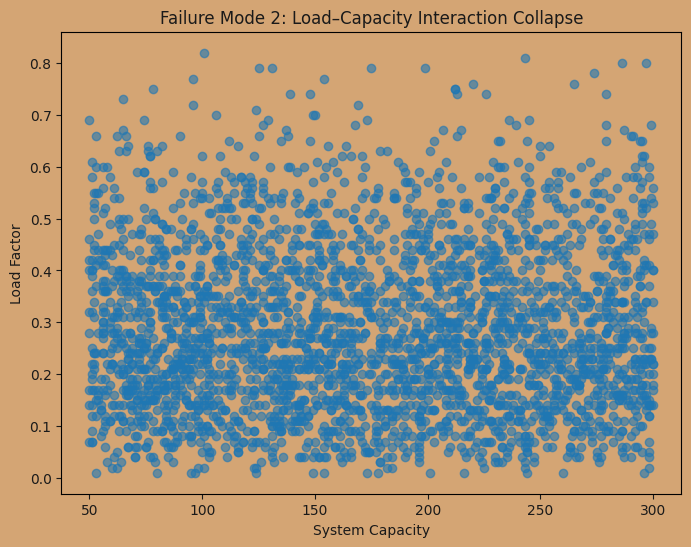

In [54]:
# -----------------------------------
# Load–Capacity Interaction Collapse
# -----------------------------------

plt.figure(figsize=(8, 6))

plt.scatter(
    df['capacity'],
    df['load_factor'],
    alpha=0.6
)

plt.xlabel("System Capacity")
plt.ylabel("Load Factor")
plt.title("Failure Mode 2: Load–Capacity Interaction Collapse")

plt.show()

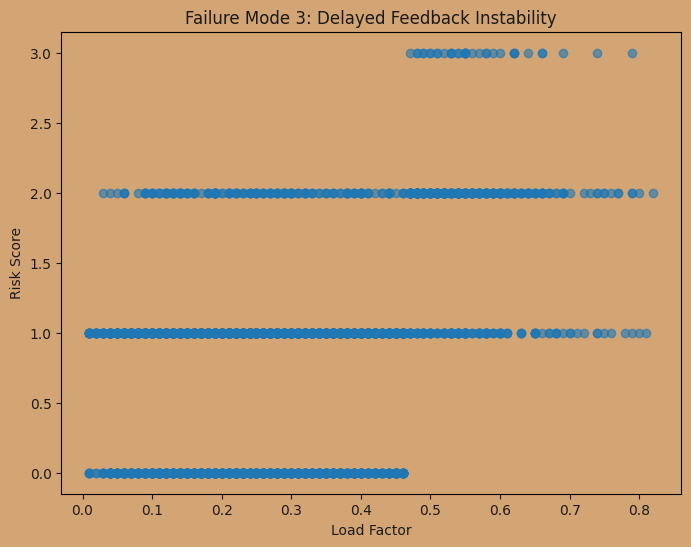

In [56]:
# -----------------------------
# Delayed Feedback Instability
# -----------------------------

plt.figure(figsize=(8, 6))

plt.scatter(
    df['load_factor'],
    df['risk_score'],
    alpha=0.6
)

plt.xlabel("Load Factor")
plt.ylabel("Risk Score")
plt.title("Failure Mode 3: Delayed Feedback Instability")

plt.show()

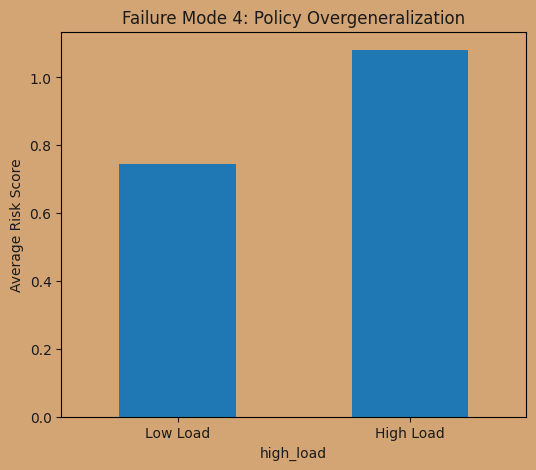

In [58]:
# -----------------------------
# Policy Overgeneralization
# -----------------------------

df['high_load'] = (df['load_factor'] > df['load_factor'].median()).astype(int)

grouped = df.groupby('high_load')['risk_score'].mean()

plt.figure(figsize=(6, 5))
grouped.plot(kind='bar')

plt.xticks([0, 1], ['Low Load', 'High Load'], rotation=0)
plt.ylabel("Average Risk Score")
plt.title("Failure Mode 4: Policy Overgeneralization")

plt.show()

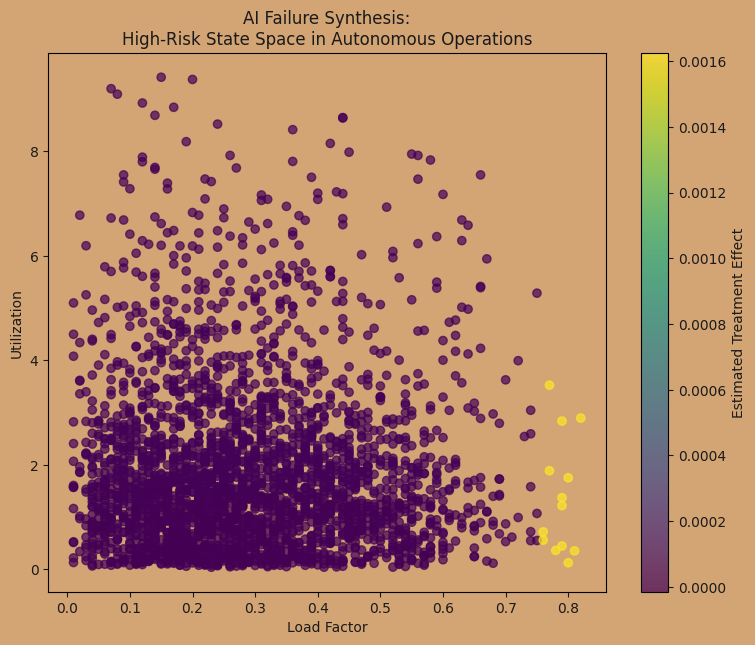

In [60]:
# -------------------------------
# Where AI Fails in State Space
# -------------------------------

plt.figure(figsize=(9, 7))

plt.scatter(
    df['load_factor'],
    df['utilization'],
    c=treatment_effect,
    cmap='viridis',
    alpha=0.7
)

plt.colorbar(label="Estimated Treatment Effect")
plt.xlabel("Load Factor")
plt.ylabel("Utilization")
plt.title("AI Failure Synthesis:\nHigh-Risk State Space in Autonomous Operations")

plt.show()